In [5]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import glob
import time
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.io import ascii
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from photutils.psf import IterativelySubtractedPSFPhotometry as ISPSF
from photutils.psf import extract_stars
from photutils.psf.groupstars import DAOGroup
from photutils import EPSFBuilder
from photutils.background import MMMBackground
from photutils.utils import make_random_cmap

In [6]:
# could add a check to see if apertures need to be plotted (in case i want to plot just the fits)
def plotting(region, ap, an, cmap, choice, savename):
    plt.imshow(region, cmap=cmap, origin='lower', norm=LogNorm(), interpolation='nearest')
    
    if choice == 'ap_only':
        ap.plot(color='blue', lw=.5, alpha=1.)
    elif choice == 'both_aps':
        ap.plot(color='blue', lw=.5, alpha=.5)
        an.plot(color='red', lw=.5, alpha=.5)
        
    plt.colorbar(fraction = 0.05)
    #plt.grid(True)
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    
    if savename != None:
        plt.savefig('images/'+savename, dpi=500)
    
    plt.gcf().set_size_inches(10, 6)
    plt.show()
    #plt.close()
    
def print_table_nicely(table):   # note: 'table' must be an astropy Table type
    for col in table.colnames:
        table[col].info.format = '%.8g'
    print(table)
    
def star_find(data, sigma, fwhm, roundness, sharphi):
    daofind = DAOStarFinder(threshold=sigma*std, fwhm=fwhm, roundlo=-roundness, roundhi=roundness, sharphi=sharphi)
    sources = daofind(data)
    return sources
    
def ap_phot(data, ap, an, bkg_method):
    all_apers = [ap, an]
    table = aperture_photometry(data, all_apers)
    
    if bkg_method == 'mean':
        bkg_mean = table['aperture_sum_1'] / an.area
        table['bkg_sum_mean'] = bkg_mean * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_mean']
        
        an_err = bkg_mean * ap.area / np.sqrt(an.area)
        ap_err = bkg_mean * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
    
    elif bkg_method == 'median':
        annulus_masks = an.to_mask(method='center')
        bkg_median = []
        for mask in annulus_masks:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_mask, _ = sigma_clipped_stats(annulus_data_1d)
            bkg_median.append(median_mask)
            
        bkg_median = np.array(bkg_median)
        table['bkg_sum_median'] = bkg_median * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_median']
        
        an_err = bkg_median * ap.area / np.sqrt(an.area)
        ap_err = bkg_median * np.sqrt(ap.area)
        poisson_err = np.sqrt(table['star_bkgsub'])
        table['counts_err'] = np.sqrt(an_err**2 + ap_err**2 + poisson_err**2)
        #table['perc_err'] = table['counts_err'] / table['star_bkgsub']
        
    else:
        print('\n\nPlease give a valid bkg_method kthx\n\n')
            
    return table

def apparent_magnitude_err(counts, apcorr, zmag_err, counts_err, apcorr_err):
    mag_err = np.sqrt(zmag_err**2 + (2.5 * np.sqrt((counts_err/counts)**2 + (apcorr_err/apcorr)**2) / np.log(10))**2)
    return mag_err

In [7]:
run_all = False  # set to False to run only the first epoch
base_dir = 'data/PAL5/'
channel = '3p6um'
#channel = '4p5um'
#method = 'aperture'
method = 'PSF'

sigma_level = 6.
sigma_level_PSF = 50.
FWHM = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundness = 0.5
sharphi = 0.9
sharphi_PSF = 0.7
#sharplo = 0.65

if channel == '3p6um':
    zmag       = 18.80    # given in/calculated using IRAC handbook, section 4.8
    zmag_err   =  0.02    # calculated from zmag = 2.5log10(F0/C), F0 = 280.9 +/- 4.1 (from IRAC, table 4.1)
    apcorr     =  1.1233  # aperture correction for 6, 6-14 pix apertures in channel 1; given on IRAC website
    apcorr_err =  0.0225  # taking accuracy to be ~2%, as mentioned in IRAC, section 4.10
elif channel == '4p5um':
    zmag       = 18.32
    zmag_err   =  0.02
    apcorr     =  1.1336
    apcorr_err =  0.0227
else:
    print('Please select a valid channel')

### Building an ePSF from one image:

File to build ePSF model from: data/PAL5/PAL5/PAL5_3p6um.fits


    x         y      id
--------- --------- ---
 938.9457 77.454039   0
903.50507 90.540962   1
  1232.93 90.280553   2
544.32821 98.568943   3
679.80363 120.45332   4
991.32804 123.49764   5
1144.5599 130.34423   6
1055.5238 135.02168   7
739.54581 135.64466   8
862.61005 139.13185   9
      ...       ... ...
251.58004 545.39115  78
410.84608 547.59338  79
594.05149 551.26372  80
362.86707 555.47335  81
1160.5267 560.19305  82
943.55403 569.06775  83
1107.2476 570.14312  84
140.08553 571.95566  85
1228.5851 586.18372  86
937.20881 593.16375  87
1191.0599 612.02303  88
Length = 89 rows
Number of model stars: 89


C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


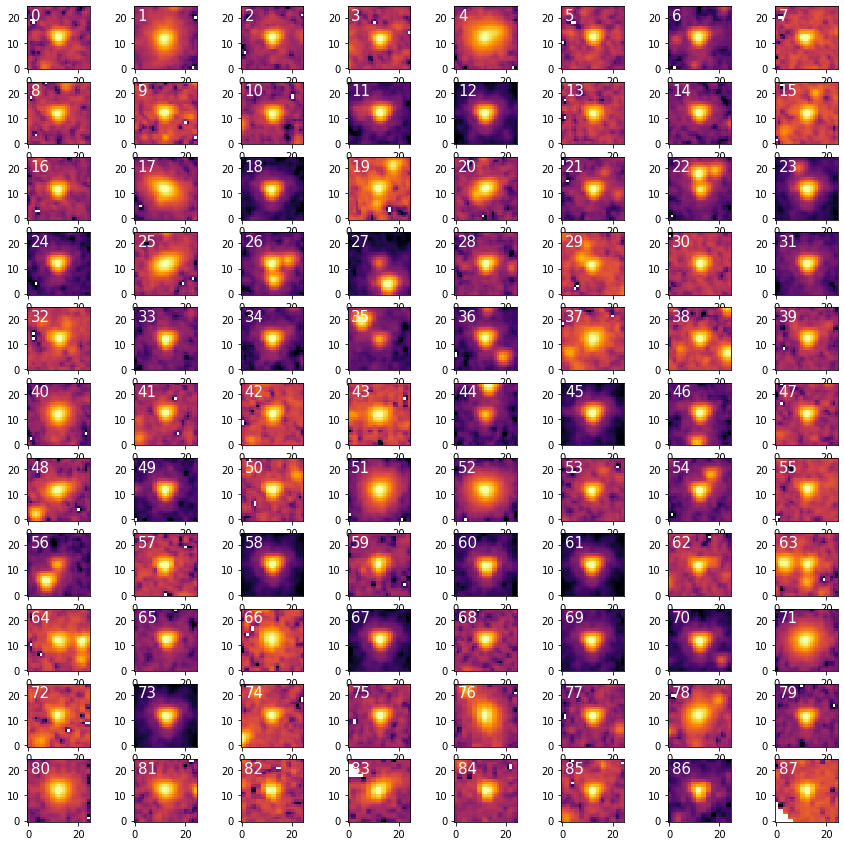

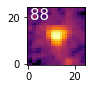

C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


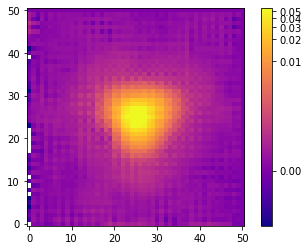

Input bad stars to remove them from the model (type -1 to exit simulation and save model):
4 17 19 20 22 25 26 27 35 36 38 44 46 48 54 56 63 64 76 78 83
[4, 17, 19, 20, 22, 25, 26, 27, 35, 36, 38, 44, 46, 48, 54, 56, 63, 64, 76, 78, 83]
    x         y      id
--------- --------- ---
 938.9457 77.454039   0
903.50507 90.540962   1
  1232.93 90.280553   2
544.32821 98.568943   3
991.32804 123.49764   5
1144.5599 130.34423   6
1055.5238 135.02168   7
739.54581 135.64466   8
862.61005 139.13185   9
888.02972 157.54766  10
      ...       ... ...
345.41985 519.02811  75
357.12766 535.91499  77
410.84608 547.59338  79
594.05149 551.26372  80
362.86707 555.47335  81
1160.5267 560.19305  82
1107.2476 570.14312  84
140.08553 571.95566  85
1228.5851 586.18372  86
937.20881 593.16375  87
1191.0599 612.02303  88
Length = 68 rows
Number of model stars: 68


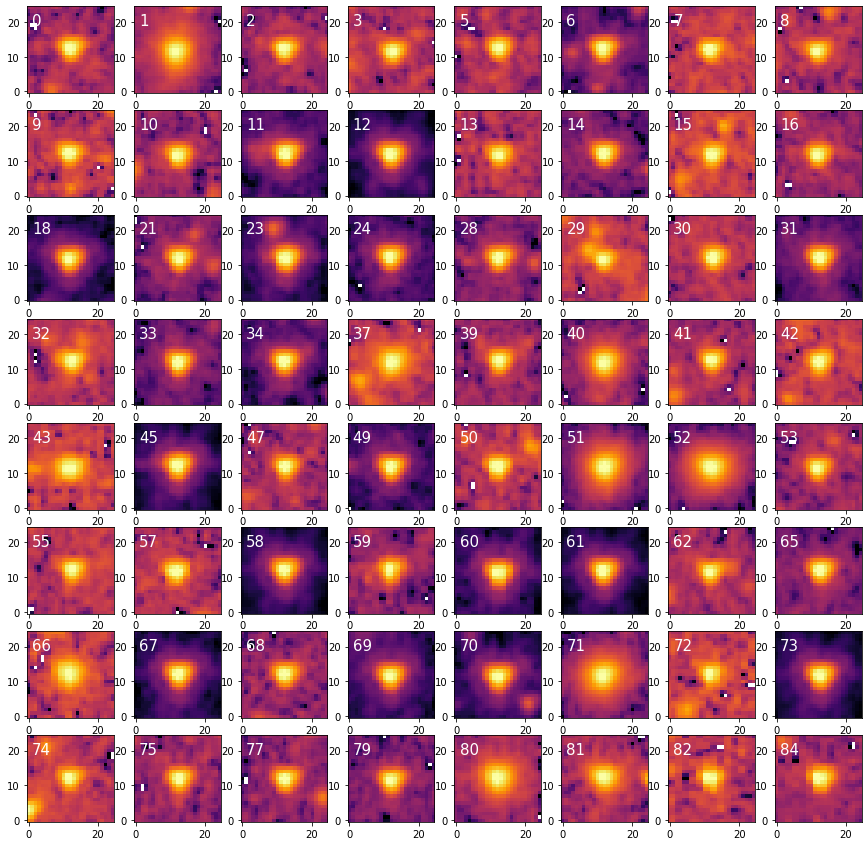

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


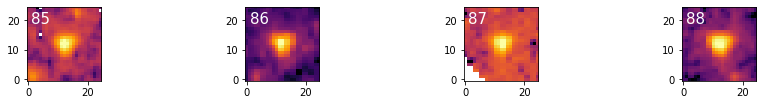

C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


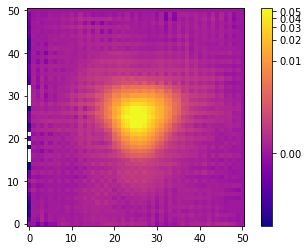

Input bad stars to remove them from the model (type -1 to exit simulation and save model):
0 1 2 3 5 7 8 9 10 13 14 15 16 29 30 32 37 39 40 41 42 43 47 50 53 55 57 59 62 66 71 72 74 75 77 80 81 82 84
[0, 1, 2, 3, 5, 7, 8, 9, 10, 13, 14, 15, 16, 29, 30, 32, 37, 39, 40, 41, 42, 43, 47, 50, 53, 55, 57, 59, 62, 66, 71, 72, 74, 75, 77, 80, 81, 82, 84]
    x         y      id
--------- --------- ---
1144.5599 130.34423   6
1259.2852 162.06051  11
143.73089 180.85102  12
1163.5581 209.67091  18
435.43996 223.84743  21
764.28022 225.86719  23
 946.5678 229.21611  24
1159.2771 243.96568  28
414.35105 260.99574  31
628.19332 273.82448  33
      ...       ... ...
1054.4456 465.14277  65
414.23437 473.17905  67
1122.0144 477.17292  68
467.61322 486.70798  69
 930.1419 495.50594  70
463.40551 510.84182  73
410.84608 547.59338  79
140.08553 571.95566  85
1228.5851 586.18372  86
937.20881 593.16375  87
1191.0599 612.02303  88
Length = 29 rows
Number of model stars: 29


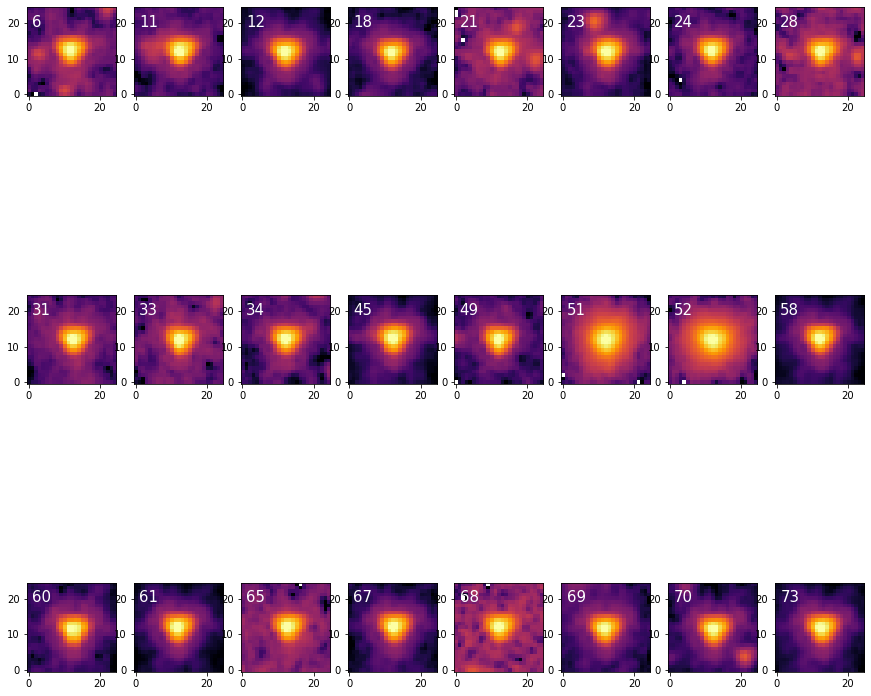

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


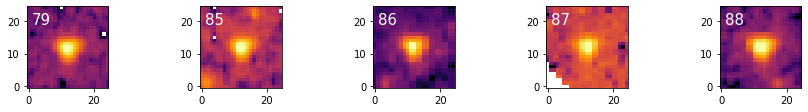

C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


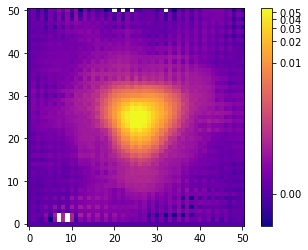

Input bad stars to remove them from the model (type -1 to exit simulation and save model):
-1
[-1]
Congrats Phil Connors, you escaped


In [23]:
###   BUILDING AN EPSF MODEL FROM ONE IMAGE   ###    

model_epoch = 1   # set to 'master' to build model from medianed image

if model_epoch == 'master':
    file_model = base_dir+'PAL5/'+'PAL5_'+channel+'.fits'
else:
    file_model = base_dir+'PAL5__e'+str(model_epoch)+'/PAL5__e'+str(model_epoch)+'_'+channel+'.fits'

print('File to build ePSF model from: {}'.format(file_model))
with fits.open(file_model) as hdu_list:
    data_model = hdu_list[0].data
    hdr_model = hdu_list[0].header
    data_model *= hdr_model['EXPTIME'] / hdr_model['FLUXCONV']

###   LOCATING STARS FOR PSF MODEL AND PLOTTING THEM   ###

mean, median, std = sigma_clipped_stats(data_model, sigma=sigma_level)

sources_model = star_find(data_model, sigma_level_PSF, FWHM, roundness, sharphi_PSF)
pos_model = np.transpose((sources_model['xcentroid'], sources_model['ycentroid']))
ap_model = CircularAperture(pos_model, r_ap)
an_model = CircularAnnulus(pos_model, r_in, r_out)
#print('No. of stars detected to build model from: {0}'.format(len(sources_model)))
#plotting(data_model, ap_model, an_model, 'Greys', choice='both_aps', savename=None)

###   DOING APERTURE PHOTOMETRY ON MODEL STARS   ###

phot_table = ap_phot(data_model, ap_model, an_model, 'median')
#print_table_nicely(phot_table)

cutout_size = 150
hsize = (cutout_size - 1) / 2
x_model = phot_table['xcenter'].value
y_model = phot_table['ycenter'].value
mask = ((x_model > hsize) & (x_model < (data_model.shape[1] - 1 - hsize)) &
        (y_model > hsize) & (y_model < (data_model.shape[0] - 1 - hsize)))
model_table = Table()
model_table['x'] = x_model[mask]
model_table['y'] = y_model[mask]

# Just numberin' the stars, don't mind me
model_table['id'] = np.array(range(len(model_table)))
print_table_nicely(model_table)

pos_model = np.transpose((model_table['x'], model_table['y']))
ap_model = CircularAperture(pos_model, r_ap)
#plotting(data_model, ap_model, an=None, cmap='Greys', choice='ap_only', savename=None)

while True:
    
    ###   BUILDING AN EPSF   ###

    nddata = NDData(data = data_model - median)
    model_stars = extract_stars(nddata, model_table, size=25)
    print('Number of model stars: {}'.format(len(model_stars)))
    figsize = 15
    ncols = 8
    nrows = int(np.floor(len(model_stars) / ncols))
    nremainder = len(model_stars) - (nrows*ncols)

    fig, ax = plt.subplots(nrows, ncols, figsize=(figsize,figsize), squeeze=True)
    ax = ax.ravel()        
    for i in range(nrows*ncols):
        norm = simple_norm(model_stars[i], 'log', percent=99.)
        ax[i].imshow(model_stars[i], norm=norm, origin='lower', cmap='inferno', interpolation='nearest')
        #ax[i].set_title(model_table['id'][i])
        ax[i].text(1, 19, model_table['id'][i], color='w', size=15)
    plt.show()

    fig, ax = plt.subplots(nrows=1, ncols=nremainder, figsize=(figsize,figsize/(figsize-nremainder)), squeeze=False)
    ax = ax.ravel()
    for i in range(nrows*ncols, len(model_stars)):
        norm = simple_norm(model_stars[i], 'log', percent=99.)
        ax[i-nrows*ncols].imshow(model_stars[i], norm=norm, origin='lower', cmap='inferno', interpolation='nearest')
        #ax[i-nrows*ncols].set_title(model_table['id'][i])
        ax[i-nrows*ncols].text(1, 19, model_table['id'][i], color='w', size=15)
    plt.show()

    epsf_builder = EPSFBuilder(oversampling=2, maxiters=10, progress_bar=True)
    epsf, fitted_stars = epsf_builder(model_stars)
    norm = simple_norm(epsf.data, 'log', percent=99.)
    plt.imshow(epsf.data, norm=norm, origin='lower', cmap='plasma')
    plt.colorbar()
    plt.show()

    print('Input bad stars to remove them from the model (type -1 to exit simulation and save model):')
    adios = [int(x) for x in input().split()]
    print(adios)

    if adios == [-1]:
        print('Congrats Phil Connors, you escaped')
        break

    #model_table.remove_rows(adios)

    model_table.add_index('id')
    byebye = model_table.loc_indices[adios]
    model_table.remove_rows(byebye)

    print_table_nicely(model_table)

Photometry method selected: PSF
File to build ePSF model from: data/PAL5/PAL5__e3/PAL5__e3_3p6um.fits


    x         y      id
--------- --------- ---
937.27568 77.470942   1
901.76349 90.486748   2
726.05653 117.01056   3
678.13524 120.60756   4
989.58157 123.50365   5
1142.8012 130.06349   6
886.49639  157.5743   7
1257.6779 161.91546   8
142.23745 181.86589   9
754.57236 182.85299  10
      ...       ... ...
733.40432 499.93905  45
462.27319 511.36413  46
344.32476 519.56023  47
741.75906   522.308  48
356.03285 536.74092  49
409.80688 548.16111  50
1020.1424 550.87262  51
592.97655 551.67395  52
942.32476 569.27076  53
335.89362 595.28796  54
1189.7991 612.08836  55
Length = 55 rows
Number of model stars: 55


C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


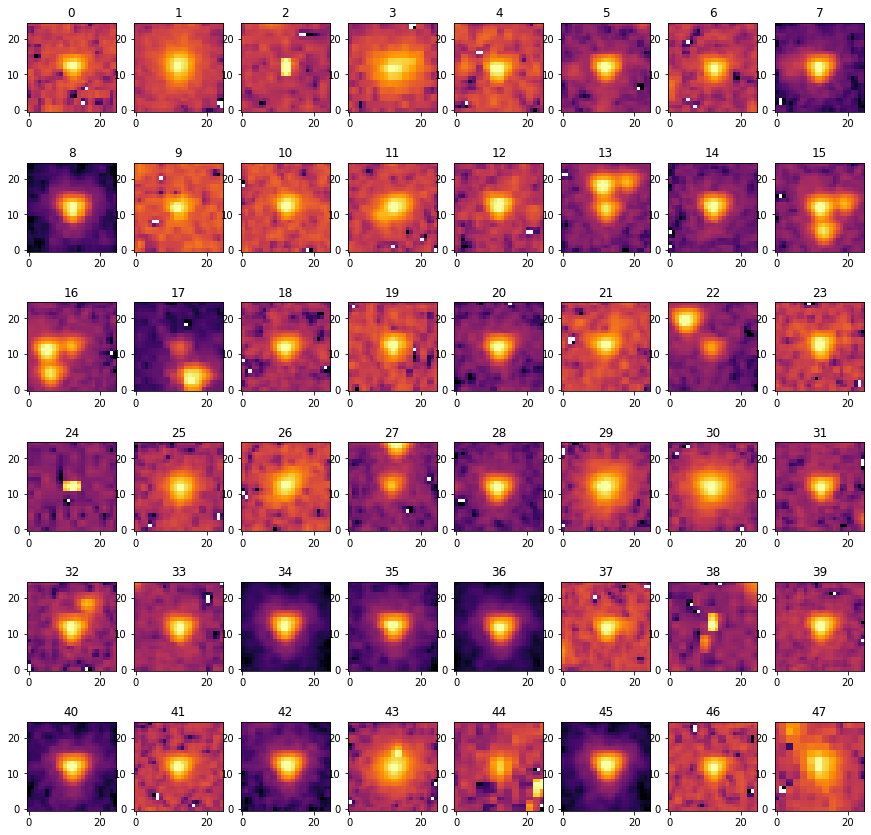

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


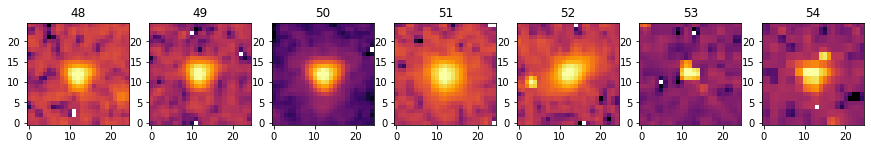

C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


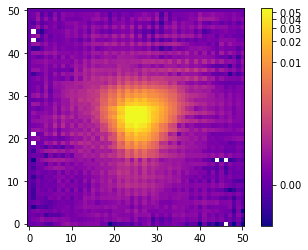

data/PAL5\PAL5__e1\PAL5__e1_3p6um.fits
EXPTIME: 71.3724
FLUXCONV: 0.1257
Mean: 44.65657043457031
Median: 43.07997131347656
Std dev: 15.755472183227539


KeyboardInterrupt: 

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


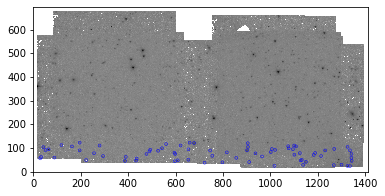

In [52]:
print('Photometry method selected: {}'.format(method))

epoch = 1  # counter to be incremented every epoch

for filename in glob.glob(base_dir+'*/PAL5__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'*/PAL5__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    
    ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###
    
    with fits.open(filename) as hdu_list:        
        print(filename)
        image_data = hdu_list[0].data
        hdr = hdu_list[0].header
        exptime = hdr['EXPTIME']
        fluxconv = hdr['FLUXCONV']
        conv = exptime / fluxconv
        print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
        data = image_data * conv
    
    file_corr = base_dir+'PAL5__e'+str(epoch)+'/PAL5__e'+str(epoch)+'_correction_'+channel+'.fits'
    with fits.open(file_corr) as hdu_list:
        data_corr = hdu_list[0].data
        
    mean, median, std = sigma_clipped_stats(data, sigma=sigma_level)
    print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))
    
    if method == 'aperture':
    
        ###   LOCATING STARS AND PLOTTING THEM   ###
        # could maybe put most of this in its own starfind function? including aperture and position bits

        sources = star_find(data, sigma_level, FWHM, roundness, sharphi)
        pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(pos, r_ap)
        annuli = CircularAnnulus(pos, r_in, r_out)
        print('No. of stars detected: {0}'.format(len(sources)))
        plotting(data, apertures, annuli, 'Greys', choice='both_aps', savename=None)

        ###   DOING APERTURE PHOTOMETRY   ###

        phot_table = ap_phot(data, apertures, annuli, 'median')
        
        phot_table['apparent_mag'] = float('NaN')
        phot_table['mag_err'] = float('NaN')
        for i in range(len(phot_table)):
            locorr = data_corr[int(phot_table['ycenter'][i].value)][int(phot_table['xcenter'][i].value)]  # location-dependent correction at star's location
            if phot_table['star_bkgsub'][i] >= 0:
                phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * phot_table['star_bkgsub'][i] / conv)
                phot_table['mag_err'][i] = apparent_magnitude_err(phot_table['star_bkgsub'][i], apcorr, zmag_err, phot_table['counts_err'][i], apcorr_err)
        
        #print_table_nicely(phot_table)
        print_table_nicely(phot_table['id', 'xcenter', 'ycenter', 'star_bkgsub', 'counts_err', 'apparent_mag', 'mag_err'])
    
    elif method == 'PSF':
        
        ###   DETECTING MORE STARS   ###
        
        daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=0.85)
        sources_PSF = daofind_PSF(data)
        
        #sources_PSF = star_find(data, sigma_level, FWHM, roundness, sharphi)
        pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
        ap_PSF = CircularAperture(pos_PSF, r_ap)
        plotting(data, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename='psf_detect_test_00.png')
        print('Number of PSF stars: {}'.format(len(sources_PSF)))
        
        ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###
        
        sources_PSF['xcentroid'].name = 'x_0'
        sources_PSF['ycentroid'].name = 'y_0'
        daogroup = DAOGroup(crit_separation=2.5*FWHM)
        star_groups = daogroup(sources_PSF)
        star_groups = star_groups.group_by('group_id')
        print_table_nicely(star_groups)
        
        ncolors = max(star_groups['group_id'])
        cmap = make_random_cmap(ncolors=ncolors, seed=1612)
        plt.imshow(data, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
        for i, group in enumerate(star_groups.groups):
            pos_group = np.transpose([group['x_0'], group['y_0']])
            ap_group = CircularAperture(pos_group, r_ap)
            ap_group.plot(color=cmap.colors[i], lw=1.)
        plt.gcf().set_size_inches(15, 9)
        plt.show()
        
        ###   DOING PSF PHOTOMETRY   ###
        
        data_nonans = np.nan_to_num(data, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash
        
        #bkg_estimation = MMMBackground()
        #fitter = LevMarLSQFitter()
        fit_rad = 5
        
        epsf.x_0.fixed = True
        epsf.y_0.fixed = True
        init_pos = Table(names=['x_0', 'y_0'], data=[sources_PSF['x_0'], sources_PSF['y_0']])
        
        start = time.perf_counter()
        PSF_photometry = ISPSF(finder = daofind_PSF,
                              group_maker = daogroup,
                              bkg_estimator = MMMBackground(),
                              psf_model = epsf,
                              fitter = LevMarLSQFitter(),
                              fitshape = 2*fit_rad+1,
                              niters = 10,
                              aperture_radius = 6.)
        PSF_table = PSF_photometry(image=data_nonans, init_guesses=init_pos)
        residual_image = PSF_photometry.get_residual_image()
        print('Time taken to fit PSF model: {}s'.format(time.perf_counter() - start))
        
        plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)
        
        PSF_table['apparent_mag'] = float('NaN')
        PSF_table['mag_err'] = float('NaN')
        for i in range(len(PSF_table)):
            locorr = data_corr[int(PSF_table['y_fit'][i])][int(PSF_table['x_fit'][i])]  # location-dependent correction at star's location
            if PSF_table['flux_fit'][i] >= 0:
                PSF_table['apparent_mag'][i] = zmag - 2.5 * math.log10(apcorr * locorr * PSF_table['flux_fit'][i] / conv)
                PSF_table['mag_err'][i] = apparent_magnitude_err(PSF_table['flux_fit'][i], apcorr, zmag_err, PSF_table['flux_unc'][i], apcorr_err)
        
        print_table_nicely(PSF_table['id', 'group_id', 'iter_detected', 'x_fit', 'y_fit', 'apparent_mag', 'mag_err'])
        #PSF_table.write('outputs/'+method+'_'+channel+'_results_e'+str(epoch)+'.txt', format='csv', overwrite=True)
        
    print('\n\n\n')
    
    if run_all == False:
        break
        
    epoch += 1

In [36]:
inyago = np.array(range(11, 17))
print(inyago)
testy = Table()
testy['id'] = inyago
print(testy)

print(len(x_model), len(y_model))

[11 12 13 14 15 16]
 id
---
 11
 12
 13
 14
 15
 16
71 71


In [36]:
print(np.nanmedian(PSF_table['mag_err']))
print(np.nanmedian(PSF_table_fixed['mag_err_fixed']))

0.05314430120091462
0.06610679478322196


In [28]:
PSF_table[:][100:500]

x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc,iter_detected,apparent_mag_fixed,mag_err_fixed
float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,float64,float64
37.04180690341026,143.28961216437358,19400.76904062756,100,89,37.04180690341026,143.28961216437358,15923.852544354326,407.1723203302066,1,15.101661576099247,0.15662201990723237
1030.7651446388145,144.35086335568914,406.776733138312,101,90,1030.7651446388145,144.35086335568914,868.1127947911401,60.11263868232931,1,18.260341551524014,0.031782112431398626
1020.2036873323019,150.22266146672996,2438.50341281913,104,90,1020.2036873323019,150.22266146672996,2546.999934809985,59.34400245333249,1,17.091709609836304,0.06032697456069083
659.3519110015895,145.15514270590253,8377.962968676737,102,91,659.3519110015895,145.15514270590253,6766.841726708757,184.00561032742618,1,16.030816897817,0.06853431584072543
1125.9223176451837,151.90864396492216,3133.323908357901,105,92,1125.9223176451837,151.90864396492216,2805.4852995837414,62.384512216735736,1,16.986761950973793,0.05627631102645058
1124.2528514398011,160.1376140137075,2988.9130454526385,114,92,1124.2528514398011,160.1376140137075,2860.303372189845,62.74399087295179,1,16.965751699150363,0.029853968984453128
873.1761254713746,153.33750973667657,1608.0996236599212,106,93,873.1761254713746,153.33750973667657,1434.754223591925,58.514851579500444,1,17.714838164742105,0.07892280545518979
551.2759834408059,154.42475053825558,751.1359412223192,107,94,551.2759834408059,154.42475053825558,1281.8053677702828,84.41509062497272,1,17.837226729627982,0.04656008819665811
42.71233780831918,154.97460123157742,4287.355401649997,108,95,42.71233780831918,154.97460123157742,3127.0999307488423,209.30489399112804,1,16.868927544611218,0.044729923669645656


In [29]:
PSF_table_fixed[:][100:500]

x_0,y_0,flux_0,id,group_id,x_fit,y_fit,flux_fit,flux_unc,iter_detected,apparent_mag_fixed,mag_err_fixed
float64,float64,float64,int32,int32,float64,float64,float64,float64,int32,float64,float64
37.04180690341026,143.28961216437358,19400.76904062756,100,89,37.04180690341026,143.28961216437358,15923.852544354326,407.1723203302066,1,15.101661576099247,0.15662201990723237
1030.7651446388145,144.35086335568914,406.776733138312,101,90,1030.7651446388145,144.35086335568914,868.1127947911401,60.11263868232931,1,18.260341551524014,0.031782112431398626
1020.2036873323019,150.22266146672996,2438.50341281913,104,90,1020.2036873323019,150.22266146672996,2546.999934809985,59.34400245333249,1,17.091709609836304,0.06032697456069083
659.3519110015895,145.15514270590253,8377.962968676737,102,91,659.3519110015895,145.15514270590253,6766.841726708757,184.00561032742618,1,16.030816897817,0.06853431584072543
1125.9223176451837,151.90864396492216,3133.323908357901,105,92,1125.9223176451837,151.90864396492216,2805.4852995837414,62.384512216735736,1,16.986761950973793,0.05627631102645058
1124.2528514398011,160.1376140137075,2988.9130454526385,114,92,1124.2528514398011,160.1376140137075,2860.303372189845,62.74399087295179,1,16.965751699150363,0.029853968984453128
873.1761254713746,153.33750973667657,1608.0996236599212,106,93,873.1761254713746,153.33750973667657,1434.754223591925,58.514851579500444,1,17.714838164742105,0.07892280545518979
551.2759834408059,154.42475053825558,751.1359412223192,107,94,551.2759834408059,154.42475053825558,1281.8053677702828,84.41509062497272,1,17.837226729627982,0.04656008819665811
42.71233780831918,154.97460123157742,4287.355401649997,108,95,42.71233780831918,154.97460123157742,3127.0999307488423,209.30489399112804,1,16.868927544611218,0.044729923669645656


In [ ]:
print(model_stars)

In [ ]:
print(fitted_stars.center_flat)

In [ ]:
nddata = NDData(data = data - median)
        model_stars = extract_stars(nddata, model_table, size=25)
        print('Number of model stars: {}'.format(len(model_stars)))
        nrows = 5
        ncols = 5
        fig, ax = plt.subplots(nrows, ncols, figsize=(15,15), squeeze=True)
        ax = ax.ravel()
        
        for i in range(nrows * ncols):
            norm = simple_norm(model_stars[i], 'log', percent=99.)
            ax[i].imshow(model_stars[i], norm=norm, origin='lower', cmap='inferno')
        plt.show()

In [ ]:
phot['apparent_mag_err'][i] = pow(zmag_err^2 + (2.5*(phot['bkgsub_flux_err'][i]^2 + ap_err^2)^0.5 / (aper_corr * phot['apparent_mag'][i] * np.log(10))), 0.5)

In [26]:
np.fabs(-34)

34.0